In [5]:
import re
import json
import math
import requests
import urllib.request
import urllib.error
import urllib.parse
from bs4 import BeautifulSoup
import pandas as pd

## 변수 설정

In [8]:
# 종목코드 url
stock_code_url = "http://kind.krx.co.kr/corpgeneral/corpList.do?method=download"
# 종목코드
stock_code = None
# 순자산
pureprice = 0

In [ ]:
순서대로 정리

## 모든 종목 코드 받아오기 (사용) ////////////////

In [7]:
# https://kind.krx.co.kr/corpgeneral/corpList.do?method=loadInitPage
# 모든 종목 코드 받아오기

def make_code(x):
    x = str(x)
    return 'A'+'0'*(6-len(x))+x
try:
    code_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download',header=0)[0]
    code_data = code_data[['종목코드','회사명']]
    code_data['종목코드'] = code_data['종목코드'].apply(make_code)
except:
    print("카카오톡 알림으로 예은이한테 종목코드 가져오기 오류났다고 알려주세요")
    print("프로그램 중지할지 실행시키고 있을지 고민고민")
print(type(code_data))
#     종목코드 가져오는 실행파일 따로 분석하는 실행파일 따로 만들기

<class 'pandas.core.frame.DataFrame'>


## 받아온 종목코드들로 실시간시세와 재무종합 얻어오기 ////////////

In [ ]:
# * 한국거래소 XML 서비스 URL

1. 실시간시세(국문)
 http://asp1.krx.co.kr/servlet/krx.asp.XMLSise?code=단축종목코드

2. 실시간시세(영문)
 http://asp1.krx.co.kr/servlet/krx.asp.XMLSiseEng?code=단축종목코드

3. 공시정보(국,영문)
 http://asp1.krx.co.kr/servlet/krx.asp.DisList4MainServlet?code=단축코드&gubun=K (K:국문/E:영문)

4. 재무종합(국문)
  http://asp1.krx.co.kr/servlet/krx.asp.XMLJemu?code=단축종목코드

5. 재무종합(영문)
  http://asp1.krx.co.kr/servlet/krx.asp.XMLJemuEng?code=단축종목코드

6. 재무종합2(국문)
   http://asp1.krx.co.kr/servlet/krx.asp.XMLJemu2?code=단축종목코드

7. 재무종합3(국문)
   http://asp1.krx.co.kr/servlet/krx.asp.XMLJemu3?code=단축종목코드

8. 텍스트 
   http://asp1.krx.co.kr/servlet/krx.asp.XMLText?code=단축종목코드

In [93]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd 

url="http://asp1.krx.co.kr/servlet/krx.asp.XMLSiseEng?code=000040"

req=urlopen(url)

result=req.read()

xmlsoup=BeautifulSoup(result,"lxml-xml")

stock = xmlsoup.find("TBL_StockInfo")
stock

stock_df=pd.DataFrame(stock.attrs, index=[0])

stock_df=stock_df.applymap(lambda x: x.replace(",",""))

stock_df

,JongName,CurJuka,DungRak,Debi,PrevJuka,Volume,Money,StartJuka,HighJuka,LowJuka,High52,Low52,UpJuka,DownJuka,Per,Amount,FaceJuka
0,KR MOTORS,1370,2,40,1330,1147486,1558539880,1350,1375,1340,1450,606,1725,935,-1.97,96137368,500


## 전체종목코드 재무 데이터 가져오기

In [184]:
# 네이버 재무제표
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate

 
# 함수 1, 원하는 재무테이블 가져오기
# code = 'A005930'
def fs_data(code):
    url = 'https://finance.naver.com/item/main.nhn?code='+code
    tables = pd.read_html(url,encoding='euc-kr')
    df = tables[3]
    df.set_index(('주요재무정보', '주요재무정보', '주요재무정보'), inplace=True)
    df.index.rename('주요재무정보', inplace=True)
    df.columns = df.columns.droplevel(2)
    return df
# 함수 2, 행열변환 및 테이블 수정
def change_df(code,fs_df):
    for num,col in enumerate(fs_df.columns):
        temp_df = pd.DataFrame({code:fs_df[col]})
        temp_df = temp_df.T
        temp_df.columns = [[col[0]]*len(fs_df),[col[1]]*len(fs_df),temp_df.columns]
        if num ==0:
            total_df = temp_df
        else:
            total_df = pd.merge(total_df,temp_df,how='outer',left_index=True,right_index=True)
    return total_df





In [186]:
# A005930(삼성전자), A000660(SK하이닉스), A207940(삼성바이오로직스), A035420(NAVER), A068270(셀트리온)

# 그러면 code의 변수를 배열로 변경하고, url~print까지를 for 반복문을 시켜주면 됩니다.
# 본문코드
code = ['005930','000660', '207940','035420','068270']

for num, code in enumerate(code):
#     print(code,num)
    dataframe=fs_data(code)
#     print(dataframe)
    dataframe_changed = change_df(code,dataframe)
    if num == 0:
        total_fs = dataframe_changed
    else:
        total_fs = pd.concat([total_fs,dataframe_changed])
print(total_fs)
total_fs.to_excel('financial.xlsx')


           최근 연간 실적                                                         \
            2018.12                                                          
주요재무정보          매출액    영업이익   당기순이익  영업이익률   순이익률 ROE(지배주주)   부채비율    당좌비율   
005930  2.43771e+06  588867  443449  24.16  18.19     19.63  36.97  204.12   
000660       404451  208438  155400  51.54  38.42     38.53  35.87   76.36   
207940         5358     557    2241  10.39  41.83      5.51  43.92  100.73   
035420        55869    9425    6279  16.87  11.24     12.97  66.09  193.84   
068270         9821    3387    2536  34.49  25.82     10.84  34.48  221.23   

                        ...   최근 분기 실적                                         \
                        ... 2021.03(E)                                          
주요재무정보      유보율 EPS(원)  ...       부채비율 당좌비율 유보율  EPS(원)  PER(배) BPS(원) PBR(배)   
005930  27531.9   6024  ...        NaN  NaN NaN   956.0   88.72    NaN    NaN   
000660  1262.49  21346  ...        NaN  NaN NaN  14

In [180]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
#  이건 기업정보 재무제표
 
# 함수 1, 원하는 재무테이블 가져오기
# code = 'A005930'
def fs_data(code):
#     print(code)
    url = 'https://comp.fnguide.com/SVO2/ASP/SVD_Finance.asp?pGB=1&cID=&MenuYn=Y&ReportGB=&NewMenuID=103&stkGb=701&gicode=' + code
#     print(url)
    res = requests.get(url)

    df = pd.read_html(res.text)
    temp_df=df[0]
    
    
    temp_df2 = df[2]
    
    temp_df=temp_df.set_index(temp_df.columns[0])
    
    temp_df=temp_df[temp_df.columns[:4]]
    
    temp_df2=temp_df2.set_index(temp_df2.columns[0])
    
    temp_df2=temp_df2[temp_df2.columns[:4]]
#     print(code, temp_df)
    temp_df = pd.concat([temp_df,temp_df2])
    
    temp_df=temp_df.loc[['매출액','영업이익','당기순이익','자산','부채']]
#     print(code, temp_df)
    return temp_df
# 함수 2, 행열변환 및 테이블 수정
def change_df(code,fs_df):
    for num,col in enumerate(fs_df.columns):
        temp_df = pd.DataFrame({code:fs_df[col]})
        temp_df = temp_df.T
        temp_df.columns = [[col]*len(fs_df),temp_df.columns]
        if num ==0:
            total_df = temp_df
        else:
            total_df = pd.merge(total_df,temp_df,how='outer',left_index=True,right_index=True)
    return total_df

In [181]:
# A005930(삼성전자), A000660(SK하이닉스), A207940(삼성바이오로직스), A035420(NAVER), A068270(셀트리온)

# 그러면 code의 변수를 배열로 변경하고, url~print까지를 for 반복문을 시켜주면 됩니다.
# 본문코드
code = ['A005930','A000660', 'A207940','A035420','A068270']

for num, code in enumerate(code):
#     print(code,num)
    dataframe=fs_data(code)
    dataframe_changed = change_df(code,dataframe)
    if num == 0:
        total_fs = dataframe_changed
    else:
        total_fs = pd.concat([total_fs,dataframe_changed])
print(total_fs)


            2017/12                                             2018/12  \
IFRS(연결)        매출액      영업이익     당기순이익         자산        부채        매출액   
A005930   2395754.0  536450.0  421867.0  3017521.0  872607.0  2437714.0   
A000660    301094.0  137213.0  106422.0   454185.0  115975.0   404451.0   
A207940      4646.0     660.0    -970.0    71831.0   32066.0     5358.0   
A035420     46785.0   11792.0    7701.0    80193.0   27141.0    55869.0   
A068270      9491.0    5078.0    3862.0    33155.0    8836.0     9821.0   

                                                     2019/12            \
IFRS(연결)      영업이익     당기순이익         자산        부채        매출액      영업이익   
A005930   588867.0  443449.0  3393572.0  916041.0  2304009.0  277685.0   
A000660   208438.0  155400.0   636583.0  168060.0   269907.0   27192.0   
A207940      557.0    2241.0    59804.0   18249.0     7016.0     917.0   
A035420     9425.0    6279.0    98812.0   39321.0    43562.0   11550.0   
A068270     3387.0    2536.0  

## 일정기간 주식 정보(사용) /////////////

In [216]:
import pandas_datareader as pdr
# 1번 방법
# DataReader API를 통해서 yahoo finance의 주식 종목 데이터를 가져온다.
# df = pdr.DataReader('005930.KS', 'yahoo')
# 2번 방법
# get_data_yahoo API를 통해서 yahho finance의 주식 종목 데이터를 가져온다.
df = pdr.get_data_yahoo('035420.KS')

df
# 선택적으로 일정 기간동안의 주식 정보를 가져오는 방법입니다.
# from datetime import datetime, timedelta
# start = datetime.today()- timedelta(days=200)
# df = pdr.DataReader('005930.KS', 'yahoo', start, datetime.today())
# df = pdr.get_data_yahoo('005930.KS', start, datetime.today() )
# df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-04-20,133600.0,130200.0,133200.0,130800.0,463915.0,129591.664062
2016-04-21,133400.0,131200.0,132000.0,133400.0,412070.0,132167.656250
2016-04-22,133000.0,131400.0,132000.0,132600.0,194870.0,131375.031250
2016-04-25,133000.0,131000.0,132400.0,132400.0,355620.0,131176.875000
2016-04-26,134400.0,129800.0,132600.0,130800.0,789600.0,129591.664062
...,...,...,...,...,...,...
2021-04-13,389000.0,382000.0,384000.0,388500.0,586643.0,388500.000000
2021-04-14,398000.0,390000.0,391500.0,391500.0,757969.0,391500.000000
2021-04-15,398500.0,386500.0,391500.0,391000.0,889538.0,391000.000000


<AxesSubplot:xlabel='Date'>

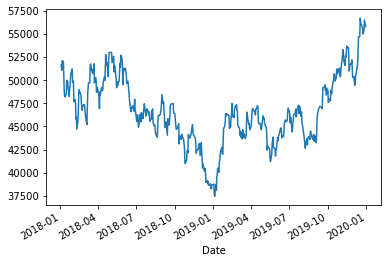

In [9]:
df['Close'].plot()

## 전체종목코드 받아오기 //////////////

In [7]:
import pandas as pd
import pandas_datareader as pdr
# 종목 타입에 따라 download url이 다름. 종목코드 뒤에 .KS .KQ등이 입력되어야해서 Download Link 구분 필요
stock_type = {
'kospi': 'stockMkt',
'kosdaq': 'kosdaqMkt'
}
# 회사명으로 주식 종목 코드를 획득할 수 있도록 하는 함수
def get_code(df, name):
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
    # 위와같이 code명을 가져오면 앞에 공백이 붙어있는 상황이 발생하여 앞뒤로 sript() 하여 공백 제거
    code = code.strip()
    return code

# download url 조합
def get_download_stock(market_type=None):
    market_type = stock_type[market_type]
    download_link = 'http://kind.krx.co.kr/corpgeneral/corpList.do'
    download_link = download_link + '?method=download'
    download_link = download_link + '&marketType=' + market_type
    
    try:
        df = pd.read_html(download_link, header=0)[0]
        return df;
    except:
        print("카카오톡 알림으로 예은이한테 종목코드 가져오기 오류났다고 알려주세요")
        print("프로그램 중지할지 실행시키고 있을지 고민고민")

    

# kospi 종목코드 목록 다운로드
def get_download_kospi():
    df = get_download_stock('kospi')
    df.종목코드 = df.종목코드.map('{:06d}.KS'.format)
    return df

# kosdaq 종목코드 목록 다운로드
def get_download_kosdaq():
    df = get_download_stock('kosdaq')
    df.종목코드 = df.종목코드.map('{:06d}.KQ'.format)
    return df

# kospi, kosdaq 종목코드 각각 다운로드
kospi_df = get_download_kospi()
print("kospi_df",kospi_df,type(kospi_df))
r.to_excel('D:/PYTHON/Stock/file.xlsx')
kosdaq_df = get_download_kosdaq()
print("kosdaq_df",kosdaq_df)
# data frame merge
code_df = pd.concat([kospi_df, kosdaq_df])
print("code_df",code_df)
# data frame정리
code_df = code_df[['회사명', '종목코드']]
print("code_df",code_df)
# data frame title 변경 '회사명' = name, 종목코드 = 'code'
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})
# 삼성전자의 종목코드 획득. data frame에는 이미 XXXXXX.KX 형태로 조합이 되어있음
code = get_code(code_df, '삼성전자')
print("code",code)
# get_data_yahoo API를 통해서 yahho finance의 주식 종목 데이터를 가져온다.
df = pdr.get_data_yahoo(code)
print("df",df)


kospi_df            회사명       종목코드             업종  \
0        DRB동일  004840.KS       고무제품 제조업   
1          DSR  155660.KS    1차 비철금속 제조업   
2        GS글로벌  001250.KS      상품 종합 도매업   
3    HDC현대산업개발  294870.KS         건물 건설업   
4          KEC  092220.KS        반도체 제조업   
..         ...        ...            ...   
799       현대위아  011210.KS  자동차 신품 부품 제조업   
800    현대코퍼레이션  011760.KS      상품 종합 도매업   
801         화신  010690.KS  자동차 신품 부품 제조업   
802        휴켐스  069260.KS    기타 화학제품 제조업   
803       흥국화재  000540.KS            보험업   

                                                  주요제품         상장일  결산월  \
0                    고무벨트(V벨트,콘베이어벨트,평벨트),프라스틱제품 제조,판매  1976-05-21  12월   
1                                               합섬섬유로프  2013-05-15  12월   
2    수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...  1976-06-26  12월   
3                               외주주택, 자체공사, 일반건축, 토목 등  2018-06-12  12월   
4                                               반도체 제조  2006-10-16  12월   
..          

### 1. 우량주 확인 (여기서부터 다사용)
##### feat 유보율 1000퍼 이상

In [126]:
urju = dataframe['최근 연간 실적'].loc['유보율']
urju[-1:][-1]
import math
if math.isnan(urju[-1:][-1]):
    print("hi")
    if urju[:-1][-1] > 1000:
        print("우량주")
        print(urju[:-1][-1])
        print(urju)
else:
    urju[-1:][-1]
    
    
    
# if buche[:-1][-1] < 100:
#     yearcondition['c4'] = True
#     messages['c4'] = "부채비율 100퍼 미만"

hi
우량주
30692.79
2018.12       27531.92
2019.12       28856.02
2020.12       30692.79
2021.12(E)         NaN
Name: 유보율, dtype: float64


### 2-1. 영업이익이 감소해서 주가가하락했을때 기업이 물량확보했는지 매각했는지 확인한다 하고 따라한다 (수정)

### 2. 영업이익은 올랐는데 당기 순이익이 하락 OR 이익 True

In [98]:
# 네이버 재무제표
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
import numpy as np

 
# 함수 1, 원하는 재무테이블 가져오기
# code = 'A005930'

def fs_data(code):
    url = 'https://finance.naver.com/item/main.nhn?code='+code
    tables = pd.read_html(url,encoding='euc-kr')
    df = tables[3]
    return df

In [99]:
code = '005930'
dataframe=fs_data(code)

dataframe.set_index(('주요재무정보', '주요재무정보', '주요재무정보'), inplace=True)
dataframe.index.rename('주요재무정보', inplace=True)
dataframe.columns = dataframe.columns.droplevel(2)
print(dataframe)
# 년도별
year = dataframe['최근 연간 실적']
iic = year.loc[['영업이익','당기순이익'],:]
# iic.iloc[:,-1:]

# 분기별
# season = dataframe['최근 분기 실적']


             최근 연간 실적                                       최근 분기 실적  \
              2018.12     2019.12     2020.12  2021.12(E)    2019.12   
주요재무정보                                                                 
매출액        2437714.00  2304009.00  2368070.00  2658610.00  598848.00   
영업이익        588867.00   277685.00   359939.00   476740.00   71603.00   
당기순이익       443449.00   217389.00   264078.00   356734.00   52270.00   
영업이익률           24.16       12.05       15.20       17.93      11.96   
순이익률            18.19        9.44       11.15       13.42       8.73   
ROE(지배주주)       19.63        8.69        9.98       12.68       8.69   
부채비율            36.97       34.12       37.07         NaN      34.12   
당좌비율           204.12      233.57      214.82         NaN     233.57   
유보율          27531.92    28856.02    30692.79         NaN   28856.02   
EPS(원)        6024.00     3166.00     3841.00     5172.00     770.00   
PER(배)           6.42       17.63       21.09       16.11      1

In [209]:
# 변수설정

yearcondition={'c1':False,'c2':False,'c3':False,'c4':False,'c5':False,'c6':False,'c7':False,'c8':False,'c9':False,'c10':False,'c11':False}
seasoncondition={'c1':False,'c2':False,'c3':False,'c4':False,'c5':False,'c6':False,'c7':False,'c8':False,'c9':False,'c10':False,'c11':False}
messages = {'c1':'','c2':'','c3':'','c4':'','c5':'','c6':'','c7':'','c8':'','c9':'','c10':'','c11':''}

In [210]:
pre=0
#  영업이익은 올랐는데 당기 순이익이 하락했다면 사기
# 영업이익이 하락하면 당기 순이익 역시 하락했다면 사지말기  (필수)
# 3 당기 순이익이 영업이익에 비해 급감했다면 사지말고 어디에 투자했는지 보기
# 당기 순이익 영업이익 둘다 오르기
oooo = False
# 영업이익 확인
for num, data in enumerate(iic.iloc[0,2:]):
    if pre == 0:
        pre = data
        continue
    
    if pre < data:
        oooo = True
    # 영업이익이 감소해서 주가가하락했을때 기업이 물량확보했는지 매각했는지 확인한다 하고 따라한다
    else:
        messages['c2'] = "영업이익 감소"
        
    pre = data

# 영업이익 오르면 당기순이익 어떤지 확인
if oooo:
    pre=0
    for num, data in enumerate(iic.iloc[1,2:]):
        if pre == 0:
            pre = data
            continue
        else:
            yearcondition['c2'] = True
            if pre < data:
                messages['c2'] = "당기순이익, 영업이익 올랐음"
            else:
                messages['c2'] = "당기순이익 감소, 영업이익에 비해 급감했는지 확인,아니라면 지르기, 급감했다면 어디에 샀는지 확인하기"
        pre = data
yearcondition

{'c1': False,
 'c2': True,
 'c3': False,
 'c4': False,
 'c5': False,
 'c6': False,
 'c7': False,
 'c8': False,
 'c9': False,
 'c10': False,
 'c11': False}

### 배당금 5퍼 이상 무조건 사기 (수정)

In [215]:
yearbedang = dataframe['최근 연간 실적'].loc['시가배당률(%)']
nowbedang = dataframe['최근 연간 실적'].loc['주당배당금(원)']
s =0
# 시가배당률
for num,data in enumerate(yearbedang[:-1]):
    s+=data
if 3<s/len(yearbedang[:-1]):
    yearcondition['c3'] = True
    messages['c3'] = "연간 배당금 3퍼 넘음"
    if 4.5<s/len(bedang[:-1]):
        messages['c3'] = "연간 배당금 4.5퍼 넘음"

# 배당수익률

data = nowbedang[:-1][-1]
pricedf = pdr.get_data_yahoo('005930.KS')
price = pricedf.iloc[-1:,3][-1]
if 3<(s/(data/price*100)):
    yearcondition['c4'] = True
    messages['c4'] = "현재 배당금 3퍼 넘음"
    if 4.5<(s/(data/price*100)):
        messages['c4'] = "현재 배당금 4.5퍼 넘음"
messages

9.9 3
9.9 3
83300.0
2.754408817635271


{'c1': '',
 'c2': '당기순이익, 영업이익 올랐음',
 'c3': '연간 배당금 3퍼 넘음',
 'c4': '',
 'c5': '부채비율 100퍼 미만',
 'c6': '',
 'c7': '이익 많이 낼때 주식 배당금 많이 줌',
 'c8': '',
 'c9': '',
 'c10': '',
 'c11': ''}

### 부채비율 100퍼 미만인지 확인

In [212]:
buche = dataframe['최근 연간 실적'].loc['부채비율']
if buche[:-1][-1] < 100:
    yearcondition['c5'] = True
    messages['c5'] = "부채비율 100퍼 미만"

### 코스피상장기업일 경우 PER = [주가 / EPS] 가 40배 미만인 회사만 (수정)
##### 매년 7% 이상의 성장을 하는 기업 중 PER이 낮고 배당수익이 높은 기업이라면 그 회사의 펀더멘탈을 확인 후 투자
###### EPS = 당기순이익 / 발행주식수
 - 1주당 얼마의 당기순이익을 냈느냐는 지표
 
###### 시가총액 = 주가 * 발행주식수

###### PER = 시가총액 / 당기순이익
###### EPS * PER = 주가


In [164]:
per = dataframe['최근 연간 실적'].loc['PER(배)']
per
if per < 40:
    

2018.12        6.42
2019.12       17.63
2020.12       21.09
2021.12(E)    16.25
Name: PER(배), dtype: float64

### 이익을 많이 낼때 주식배당금을 많이 주는지

In [213]:
besung = dataframe['최근 연간 실적'].loc['배당성향(%)']
if besung[:-1][-1] > 50:
    yearcondition['c7'] = True
    messages['c7'] = "이익 많이 낼때 주식 배당금 많이 줌"
messages

{'c1': '',
 'c2': '당기순이익, 영업이익 올랐음',
 'c3': '연간 배당금 3퍼 넘음',
 'c4': '',
 'c5': '부채비율 100퍼 미만',
 'c6': '',
 'c7': '이익 많이 낼때 주식 배당금 많이 줌',
 'c8': '',
 'c9': '',
 'c10': '',
 'c11': ''}

### PBR : 주가순자산비율 PBR = [주가 / BPS] (수정)
##### PBR < 1 이면 주당 순자산이 주가보다 더 크다는 의미로 현재 주가가 저평가돼있음

BPS = 순자산 / 총주식수

In [214]:
pbr = dataframe['최근 연간 실적'].loc['PBR(배)']
if pbr[:-1][-1] < 1:
    yearcondition['c7'] = True
    messages['c7'] = "현재 주가 저평가"
messages

{'c1': '',
 'c2': '당기순이익, 영업이익 올랐음',
 'c3': '연간 배당금 3퍼 넘음',
 'c4': '',
 'c5': '부채비율 100퍼 미만',
 'c6': '',
 'c7': '이익 많이 낼때 주식 배당금 많이 줌',
 'c8': '',
 'c9': '',
 'c10': '',
 'c11': ''}

### 순자산 구하기////////////

In [97]:
code = "A005930"
price_url = 'http://comp.fnguide.com/SVO2/ASP/SVD_main.asp?pGB=1'
params = {'query': code}
price = requests.get(price_url, params=params)
d = pd.read_html(price.text)
data = d[10]
data.set_index(('IFRS(연결)', 'IFRS(연결)'), inplace=True)
data.index.rename('ifrf', inplace=True)
yearfin = data.loc[:, 'Annual'].iloc[:, :-1]
seasonfin = data.loc[:, 'Net Quarter'].iloc[:, :-1]
data
d[0]

,0,1,2,3
0,종가/ 전일대비,"83,300/ -600",거래량,15287311
1,52주.최고가/ 최저가,"91,000/ 47,850",거래대금(억원),12773
2,수익률(1M/ 3M/ 6M/ 1Y),+1.71/ -4.25/ +38.83/ +62.06,외국인 보유비중,54.76
3,"시가총액(상장예정포함,억원)",5592463,베타(1년),1.10640
4,"시가총액(보통주,억원)",4972829,액면가,100
5,NaN,NaN,NaN,NaN
6,발행주식수(보통주/ 우선주),"5,969,782,550/ 822,886,700",유동주식수/비율(보통주),"4,706,589,110 / 78.84"


### 발행주식수 가져오기

In [96]:
# def stockcount(code):
code = "A005930"
price_url = 'http://comp.fnguide.com/SVO2/ASP/SVD_main.asp?pGB=1'
params = {'query':code}
price = requests.get(price_url,params=params)
d = pd.read_html(price.text)[0].loc[6,1]
int(d.split('/')[0].replace(" ","").replace(",",""))
#     return int(d[0].loc[6,1].split('/')[0].replace(" ","").replace(",",""))

5969782550

### 전략 1 RSI

#### RSI지표는 천장과 바닥을 찾기 매우 쉽다는 장점이 있고 RSI가 이전의 주가로 추세의 흐름을 판단하는 만큼 박스권장세에서 등락을 반복하는 상황에서만 매우 큰 효율을 보인다.

##### RSI지표 공식 알아보기




U = 현재가격이 전일가격보다 상승하였을때의 값

D = 현재가격이 전일가격보다 하락하였을때의 값



AD (average ups) = U값을 일정기간동안 평균한 값

AU (average downs) = D값을 일정기간동안 평균한 값



AU와 AD를 사용하여서 RS(Relative strength) 값을 구해낼 수 있다. 

### RS = AU / AD

이제 위와같은 수식으로 이제 RSI 값을 구해낼 수 있다.

### RSI = RS / 1+RS


##### RSI 지표 매매 활용 방법



사용 시점 - 박스권장세에서 등락을 반복하는 시장에서 사용하여야 높은 효율을 준다.



RSI 지표 기본 전략



RSI 70 % 이상은 초과매수 국면 ( 매도시점 )

RSI 30 % 이하는 초과매도 국면 ( 매수시점 )



◆ RIS 70 % 이상 , 30 % 이하 상황에서 추세가 연장이될때 전략



RSI 70 % 이상 지표가 계속 머물러 있다면 70% 이탈시 ( 매도시점 )

RSI 30 % 이하 지표가 계속 머물러 있다면 30% 이탈시 ( 매수시점 )



RSI 지표의 다른 전략



RSI 50% 하향돌파시 ( 매도시점 )

RSI 50% 상향돌파시 ( 매수시점 )



RSI 지표 자주사용되는 전략 



Failure Swing



Top Failure Swing = RSI 70% 이상에서 고점을 형성 후 이 고점을 돌파하지 못하고 하락할 때 직전 고점 형성 이후의 최저점을 하향 돌파하는 시점 (매도시점)



Bottom Failure Swing = RSI 30% 이하에서 저점을 형성 후 이 저점보다 더 떨어지지 않고 상승반전될 때 직전 저점 형성 이후 최고점을 상향 돌파하는 시점 (매수시점)


### 전략 2 볼린저밴드

#### 볼린저밴드 3개의 선의 의미



1. 상한선 : 20일 이동평균선 +표준편차 2

2. 중심선 : 20일 이동평균선

3. 하한선 : 20일 이동평균선 - 표준편자 2

#### 볼린저밴드 기본 투자기법 



1. 주가가 볼린저밴드 상한선 돌파시 매도시점

2. 주가가 볼린저밴드 하한선 돌파시 매수시점



볼린저밴드 심화 투자기법



횡보구간 적용



1. 긴시간 주가가 횡보하여 밴드의 폭이 좁아졌을때 (횡보구간) : 상한선 돌파시 매수시점

2. 긴시간 주가가 횡보하여 밴드의 폭이 좁아졌을때 (횡보구간) : 하한선 돌파시 매도시점



+꿀팁 ) 강한추세시 매수시점 



주가가 상승추세일경우 : 밴드의 폭이 좁아들었을때 추가매수 진행